# Conformal inference: classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from utils import print_image_by_id, plot_scores

MNIST dataset

In [2]:
# # Fetch MNIST data without using pandas
# mnist = fetch_openml('mnist_784', data_home='/Users/mn9lu5b/OneDrive - Allianz/AAC Use Cases', as_frame=False)

# X, y = mnist.data, mnist.target

Zalando's Fashion-MNIST dataset

In [3]:
fashion_mnist = fetch_openml(name='Fashion-MNIST', data_home='/Users/mn9lu5b/OneDrive - Allianz/AAC Use Cases', version=1, as_frame=False)

X, y = fashion_mnist.data, fashion_mnist.target

/Users/mn9lu5b/Library/CloudStorage/OneDrive-Allianz/Github/Private AZ Account/uncertainty_quantification/env_uq/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
print(X.shape, y.shape)

(70000, 784) (70000,)


In [5]:
#print(mnist.DESCR)

In [25]:
# Labels are strings, we need to convert them to int
le = LabelEncoder()

y = le.fit_transform(y)

View the data:

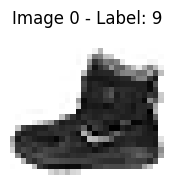

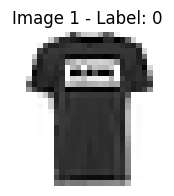

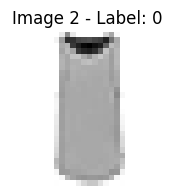

In [26]:
images = X.copy()

# Plotting each of the first few images separately
for i in range(3):
    print_image_by_id(id=i, images=images, labels=y)

Partition the data:

In [27]:
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=0.8, random_state=42, stratify=y_rest1)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=0.8, random_state=42, stratify=y_rest2)

In [28]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_calib = scaler.transform(X_calib)
X_new = scaler.transform(X_new)

print(X_train.shape)
print(X_test.shape)
print(X_calib.shape)
print(X_new.shape)

(56000, 784)
(11200, 784)
(2240, 784)
(560, 784)


Train some base model:

In [55]:
model = RandomForestClassifier(random_state=42)
#model = GaussianNB()
#model = SVC(gamma='auto', probability=True)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Naive approach

In [56]:
y_probs = model.predict_proba(X_calib)
y_pred = model.predict(X_calib)

print(y_probs.shape)

alpha = 0.05
print(f"Accuracy: {(y_pred == y_calib).mean() * 100:.4f}%")

high_prob = np.amax(y_probs, axis=1)
print(high_prob.shape)

high_prob_indices = np.where(high_prob >= (1 - alpha))

# Let's count how often we are correct
matches = (y_pred == y_calib)

# Calculate marginal/average coverage
coverage = np.mean(matches[high_prob_indices])
print(f"Coverage: {coverage:.4f}")

(2240, 10)
Accuracy: 88.3036%
(2240,)
Coverage: 0.9987


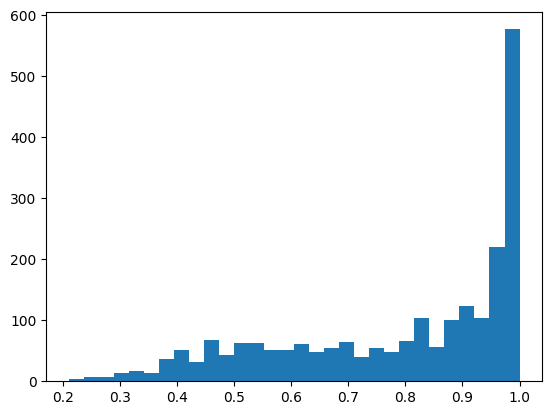

In [57]:
# Plot the distribution of the probabilities
plt.hist(high_prob, bins=30);

In [58]:
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_calib, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       224
           1       0.99      0.96      0.98       224
           2       0.76      0.78      0.77       224
           3       0.87      0.92      0.89       224
           4       0.75      0.84      0.79       224
           5       0.97      0.97      0.97       224
           6       0.77      0.57      0.65       224
           7       0.96      0.95      0.96       224
           8       0.95      0.97      0.96       224
           9       0.97      0.98      0.97       224

    accuracy                           0.88      2240
   macro avg       0.88      0.88      0.88      2240
weighted avg       0.88      0.88      0.88      2240



## Conformal approach

In [59]:
n = len(y_calib)

y_score = model.predict_proba(X_calib)

# Select the probabilities for the true class
prob_true_class = y_score[np.arange(n), y_calib]

# Turn into conformal uncertainty scores (larger means more uncertain)
uncertainty_scores = 1 - prob_true_class

In [60]:
# Set the confidence level
alpha = 0.05
q_level = np.ceil((n+1) * (1-alpha))/n    # apply finite sample correction for small samples

qhat = np.quantile(uncertainty_scores, q_level, method='higher') 
print('Quantile:', qhat)

Quantile: 0.78


Visualize the uncertainty scores

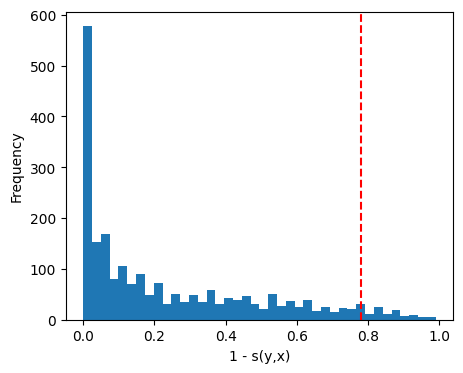

In [61]:
plt.figure(figsize=(5, 4))
plt.hist(uncertainty_scores, bins=40)
plt.axvline(x=qhat, color='r', linestyle='--')
plt.xlabel('1 - s(y,x)')
plt.ylabel('Frequency')
plt.show()


Calculate prediction set per example:

In [62]:
prediction_sets = (1 - model.predict_proba(X_calib) <= qhat)
prediction_sets

array([[False, False, False, ..., False,  True, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

Check sizes of prediction sets

In [63]:
pd.Series(prediction_sets.sum(axis=1)).value_counts()

1    1639
2     550
3      50
0       1
Name: count, dtype: int64

View predictions alongside prediction sets:

True label: 8 -> Prediction: 8 -> Pred. set: ['8']


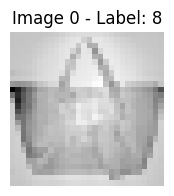

True label: 2 -> Prediction: 2 -> Pred. set: ['2' '4']


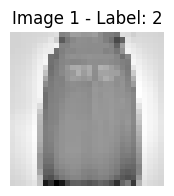

True label: 3 -> Prediction: 3 -> Pred. set: ['3']


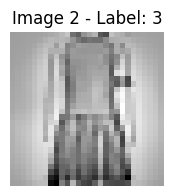

True label: 3 -> Prediction: 6 -> Pred. set: ['3' '6']


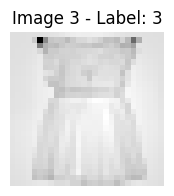

In [64]:
for i in range(4):
    print(f"True label: {y_calib[i]} -> Prediction: {y_pred[i]} -> Pred. set: {le.classes_[prediction_sets[i]]}")
    print_image_by_id(id=i, images=X_calib, labels=y_calib)

## MAPIE package

In [1]:
from mapie.classification import MapieClassifier

In [65]:
mapie_classifier = MapieClassifier(estimator=model, cv='prefit', method='score', n_jobs=-1)

mapie_classifier = mapie_classifier.fit(X_calib, y_calib)

#alpha = [0.05, 0.1, 0.2]
alpha = [0.05]
y_pred, y_set = mapie_classifier.predict(X_new, alpha=alpha)

y_pred_proba_max = np.max(y_score, axis=1)

y_set = np.squeeze(y_set)
y_set.shape

(560, 10)

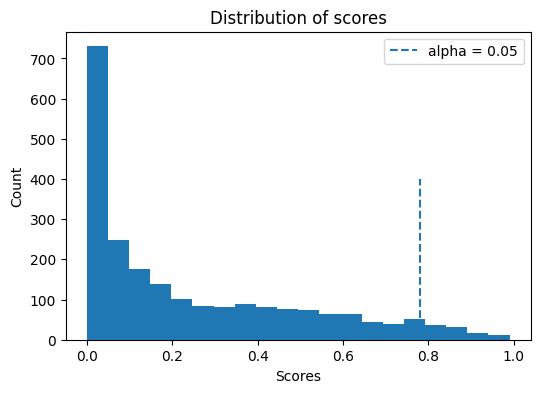

In [70]:
n = len(mapie_classifier.conformity_scores_)

scores = mapie_classifier.conformity_scores_

quantiles = mapie_classifier.quantiles_

plot_scores(n, alpha, scores, quantiles, bins=20)

In [2]:
from mapie.metrics import classification_coverage_score_v2, classification_mean_width_score

In [71]:
coverage_scores = classification_coverage_score_v2(y_new, y_set)

print(f"Marginal coverage: {coverage_scores[0]:.3f}")

Marginal coverage: 0.941


In [72]:
setsize = classification_mean_width_score(y_set)

print(f"Avg. set size: {setsize:.2f}")

Avg. set size: 1.27


View predictions alongside prediction sets:

True label: 6 -> Prediction: 4 -> Pred. set: ['4' '6']


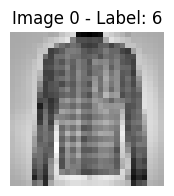

True label: 0 -> Prediction: 0 -> Pred. set: ['0']


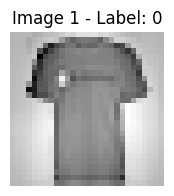

True label: 0 -> Prediction: 0 -> Pred. set: ['0']


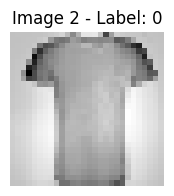

True label: 6 -> Prediction: 4 -> Pred. set: ['4' '6']


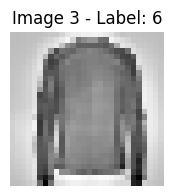

In [73]:
for i in range(4):
    print(f"True label: {y_new[i]} -> Prediction: {y_pred[i]} -> Pred. set: {le.classes_[y_set[i]]}")
    print_image_by_id(id=i, images=X_new, labels=y_new)

Check sizes:

In [74]:
pd.Series(y_set.sum(axis=1)).value_counts()

1    427
2    117
3     16
Name: count, dtype: int64